In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
load_dataset = False
load_model = True

# Dataset preparing

In [3]:
from dataset.fact_dataset_generator import FactDatasetGenerator
import numpy as np
import sys
import pandas as pd

In [4]:
true_dist_size = 10000
dataset = FactDatasetGenerator(number_person=1000,  distribution="zipf", dataset_folder='./dataset/data/', food_list_name="food_list_small.txt",true_dist_size=true_dist_size, experiment_path="experiment/medium_dataset/data/")

In [5]:
if load_dataset:
    dataset.load_dataset()
    true_dist = dataset.true_dist 
    training_data = dataset.training_data
else:
    # Generate all possible facts
    temp = dataset.generate_all_possibilities()
    # Sample true dist (zipf)
    true_dist = dataset.generate_true_dist()
    # Sample training data uniformly, %80 of true dist
    training_dataset_size = int(0.3 * true_dist_size)
    training_data = dataset.sample_training_data(training_dataset_size,true_dist.tolist())
    print(dataset.vocab_size)
    print(len(temp))

1098
101000


In [6]:
true_dist_df = pd.DataFrame(true_dist,columns=["facts"])

In [7]:
true_dist_df

,facts
0,"Derek,tuna tartare"
1,"Gibby,lobster roll sandwich"
2,"Amalee,lobster bisque"
3,"Robbi,greek salad"
4,"Perrine,bread pudding"
...,...
9995,"Lesley,filet mignon"
9996,"Koressa,shrimp and grits"
9997,"Hervey,grilled cheese sandwich"
9998,"Lela,mussels"


In [8]:
true_duplicates_count = true_dist_df.groupby(list(true_dist_df.columns)).size().reset_index(name='count_true')


In [9]:
true_duplicates_count

,facts,count_true
0,"Abbe,beef carpaccio",1
1,"Abbe,creme brulee",1
2,"Abbe,frozen yogurt",1
3,"Abbe,ramen",1
4,"Abbi,crab cakes",1
...,...,...
4238,"Zita,breakfast burrito",1
4239,"Zita,red velvet cake",3
4240,"Zorine,club sandwich",1
4241,"Zorine,hamburger",1


In [10]:
training_dist_df = pd.DataFrame(training_data,columns=["facts"])
training_duplicates_count = training_dist_df.groupby(list(training_dist_df.columns)).size().reset_index(name='count_train')

In [11]:
training_duplicates_count

,facts,count_train
0,"Abbe,frozen yogurt",1
1,"Abbi,crab cakes",1
2,"Abbi,grilled cheese sandwich",1
3,"Abbi,spaghetti bolognese",1
4,"Abbie,apple pie",1
...,...,...
1591,"Zechariah,huevos rancheros",3
1592,"Zedekiah,beef carpaccio",1
1593,"Zedekiah,pho",1
1594,"Zedekiah,spring rolls",1


In [12]:
import torch
## get the training  datasets
train_dataset = [torch.tensor(x, dtype=torch.long) for x in dataset.tokenized_training_data]


In [13]:
from torch.utils.data import Dataset

## create a dataset class
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming each item in data is a sequence and we use the same sequence shifted by one as the target
        x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
        y = torch.tensor(self.data[idx][1:], dtype=torch.long)
        #print(x)
        #print(y)
        
        return x, y


## create the datasets
train_data = MyDataset(train_dataset)
# test_data = MyDataset(test_dataset)

print(train_data)

# Model preparing

In [14]:
## import mingpt
sys.path.append('minGPT/')
from mingpt.model import GPT
from mingpt.utils import set_seed
set_seed(42)

model_config = GPT.get_default_config()
model_config.n_layer=12
model_config.n_head=8
model_config.n_embd=512
model_config.vocab_size = dataset.vocab_size
model_config.model_type = None
model_config.block_size = 2

# model_config.model_type = 'gpt-nano'
# model_config.vocab_size = dataset.vocab_size
# model_config.block_size = 2

model = GPT(model_config).to("cuda")

number of parameters: 38.39M


In [15]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-5 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 20000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_data)

running on device cuda


# Training the model

In [18]:
best_iter = 100000000000000
best_epoch = 0
def batch_end_callback(trainer):
    global best_iter
    global best_epoch
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 100:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        if trainer.loss.item() < best_iter:
            best_iter = trainer.loss.item()
            best_epoch = trainer.iter_num
            torch.save(model.state_dict(), dataset.experiment_path[:-5] + "model.pt")
trainer.set_callback('on_batch_end', batch_end_callback)

if load_model:
    model.load_state_dict(torch.load(dataset.experiment_path[:-5]+ "model.pt"))
else:
    trainer.run()
    print(f"Best loss is: {best_iter} on epoch: {best_epoch}")

In [19]:
# now let's perform some evaluation
model.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(1098, 512)
    (wpe): Embedding(2, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=512, out_features=1536, bias=True)
          (c_proj): Linear(in_features=512, out_features=512, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=512, out_features=2048, bias=True)
          (c_proj): Linear(in_features=2048, out_features=512, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_f

# Generate unconditioned facts

In [20]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [21]:
n_sequences = 1000
from collections import defaultdict
collected_generations = []

for _ in range(n_sequences):
    x = torch.Tensor([0]).unsqueeze(0).long().to("cuda")
    y_gen = model.generate(x, 2, do_sample=True)
    name = food_item = dataset.decode([y_gen[0][1]])[0]
    food_item = dataset.decode([y_gen[0][2]])[0]
    collected_generations.append(f"{name},{food_item}")

In [22]:
collected_generations_df = pd.DataFrame(collected_generations, columns=["facts"])

In [23]:
collected_generations_counts = collected_generations_df.groupby(list(collected_generations_df.columns)).size().reset_index(name='count_generated')


In [24]:
collected_generations_counts

,facts,count_generated
0,"Abbi,grilled cheese sandwich",1
1,"Abbot,edamame",1
2,"Abbot,tiramisu",1
3,"Abbye,takoyaki",1
4,"Abdul,Candie",1
...,...,...
535,"pancakes ,ramen",1
536,"pork chop ,prime rib",1
537,"pulled pork sandwich ,chocolate mousse",1
538,"steak ,Roch",1


In [25]:
# Merge true dist and training dist dataframes, outer is used to include data that is not in training data as well
merged_df = pd.merge(true_duplicates_count, training_duplicates_count, on='facts', how='outer')

In [26]:
# Add generated_df to true and training dfs 
# outer can be used to include all facts in true dist
# inner can be used to only show the comparison of generated facts
comparison_df = pd.merge(merged_df, collected_generations_counts, on='facts', how='outer')

In [27]:
comparison_df

,facts,count_true,count_train,count_generated
0,"Abbe,beef carpaccio",1.0,NaN,NaN
1,"Abbe,creme brulee",1.0,NaN,NaN
2,"Abbe,frozen yogurt",1.0,1.0,NaN
3,"Abbe,ramen",1.0,NaN,NaN
4,"Abbi,crab cakes",1.0,1.0,NaN
...,...,...,...,...
4291,"pancakes ,ramen",NaN,NaN,1.0
4292,"pork chop ,prime rib",NaN,NaN,1.0
4293,"pulled pork sandwich ,chocolate mousse",NaN,NaN,1.0
4294,"steak ,Roch",NaN,NaN,1.0


In [28]:
# Fill in 0 for facts that not appear
comparison_df = comparison_df.fillna(0)

In [29]:
# Normalize the counts by length
comparison_df["count_generated"] = comparison_df['count_generated']/len(collected_generations)
comparison_df["count_train"] = comparison_df['count_train']/len(training_data)
comparison_df["count_true"] = comparison_df['count_true']/len(true_dist)


In [30]:
comparison_df = comparison_df.sort_values(by=['count_generated'], ascending=False)

In [31]:
comparison_df

,facts,count_true,count_train,count_generated
1863,"Isadora,ceviche",0.0856,0.077333,0.077
88,"Albertine,greek salad",0.0276,0.028000,0.034
2206,"Kelli,creme brulee",0.0415,0.040000,0.029
2204,"Keefer,sashimi",0.0140,0.011667,0.021
3274,"Philipa,filet mignon",0.0162,0.018000,0.021
...,...,...,...,...
1537,"Gina,mussels",0.0001,0.000333,0.000
1538,"Gina,oysters",0.0001,0.000000,0.000
1539,"Gina,panna cotta",0.0001,0.000000,0.000
1540,"Gina,samosa",0.0001,0.000000,0.000


In [32]:
comparison_df.sum()

facts              Isadora,ceviche Albertine,greek salad Kelli,cr...
count_true                                                       1.0
count_train                                                      1.0
count_generated                                                  1.0
dtype: object

<Axes: >

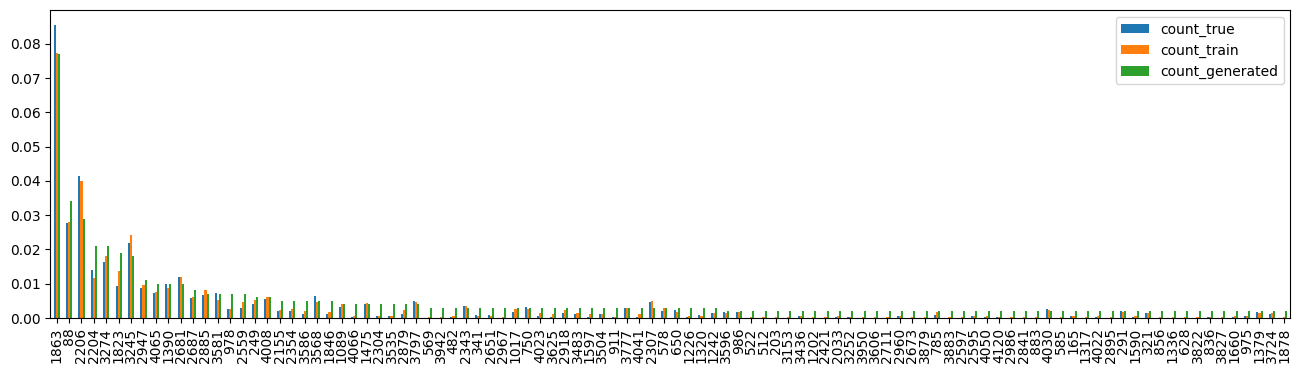

In [33]:
import matplotlib.pyplot as plt
import numpy as np
# Only the top 100 facts graphed for visibility 
comparison_df[:100].plot.bar(figsize=(16, 4))

## Hallucination rates

In [34]:
# True hallucination rate (generations not in true dist)
true_hallucinations = pd.merge(collected_generations_counts, true_duplicates_count, on='facts', how='left')


In [35]:
true_hallucinations

,facts,count_generated,count_true
0,"Abbi,grilled cheese sandwich",1,1.0
1,"Abbot,edamame",1,1.0
2,"Abbot,tiramisu",1,1.0
3,"Abbye,takoyaki",1,2.0
4,"Abdul,Candie",1,NaN
...,...,...,...
535,"pancakes ,ramen",1,NaN
536,"pork chop ,prime rib",1,NaN
537,"pulled pork sandwich ,chocolate mousse",1,NaN
538,"steak ,Roch",1,NaN


In [36]:
true_hallucinations = true_hallucinations.fillna(0)
number_of_true_hallucinations =true_hallucinations["count_true"].value_counts()[0]
true_hallucinations_rate = number_of_true_hallucinations / len(collected_generations)
print(f"Rate of true hallucinations: {true_hallucinations_rate} ")

Rate of true hallucinations: 0.053 


In [37]:
# Naive hallucination rate (every generation not in training data)
naive_hallucinations = pd.merge(collected_generations_counts, training_duplicates_count, on='facts', how='left')

In [38]:
naive_hallucinations

,facts,count_generated,count_train
0,"Abbi,grilled cheese sandwich",1,1.0
1,"Abbot,edamame",1,1.0
2,"Abbot,tiramisu",1,1.0
3,"Abbye,takoyaki",1,2.0
4,"Abdul,Candie",1,NaN
...,...,...,...
535,"pancakes ,ramen",1,NaN
536,"pork chop ,prime rib",1,NaN
537,"pulled pork sandwich ,chocolate mousse",1,NaN
538,"steak ,Roch",1,NaN


In [39]:
naive_hallucinations = naive_hallucinations.fillna(0)
number_of_naive_hallucinations = naive_hallucinations["count_train"].value_counts()[0]
naive_hallucinations_rate = number_of_naive_hallucinations / len(collected_generations)
print(f"Rate of naive hallucinations: {naive_hallucinations_rate} ")

Rate of naive hallucinations: 0.054 


### Monofact rate

In [40]:
MF = training_duplicates_count["count_train"].value_counts()[1] / len(training_data)
MF

0.44866666666666666

In [41]:
training_duplicates_count["count_train"].value_counts()[1]

1346

### Miscalibration

In [52]:
from lib.calibration import miscalibration

In [53]:
comparison_sorted_by_generated = comparison_df.sort_values(by='count_generated', ascending=False)

In [54]:
miscalibration_rate = miscalibration(comparison_sorted_by_generated['count_generated'], comparison_sorted_by_generated['count_true'])
miscalibration_rate

Adaptive binning with 12 bins
bin with g_proba / p_proba 0.077 0.0856
bin with g_proba / p_proba 0.063 0.0691
bin with g_proba / p_proba 0.079 0.06149999999999999
bin with g_proba / p_proba 0.08300000000000002 0.067
bin with g_proba / p_proba 0.08300000000000005 0.04849999999999999
bin with g_proba / p_proba 0.08200000000000003 0.028100000000000003
bin with g_proba / p_proba 0.08200000000000006 0.0185
bin with g_proba / p_proba 0.08300000000000006 0.0271
bin with g_proba / p_proba 0.08300000000000006 0.0159
bin with g_proba / p_proba 0.08300000000000006 0.020599999999999997
bin with g_proba / p_proba 0.08300000000000006 0.016999999999999998
bin with g_proba / p_proba 0.08300000000000006 0.021399999999999995
bin with g_proba / p_proba 0.036000000000000025 0.5197


0.5301661392405064

In [55]:
miscalibration(comparison_sorted_by_generated['count_generated'], comparison_sorted_by_generated['count_train'])

Adaptive binning with 12 bins
bin with g_proba / p_proba 0.077 0.07733333333333334
bin with g_proba / p_proba 0.063 0.068
bin with g_proba / p_proba 0.079 0.06766666666666667
bin with g_proba / p_proba 0.08300000000000002 0.06999999999999999
bin with g_proba / p_proba 0.08300000000000005 0.05333333333333334
bin with g_proba / p_proba 0.08200000000000003 0.033999999999999996
bin with g_proba / p_proba 0.08200000000000006 0.026666666666666665
bin with g_proba / p_proba 0.08300000000000006 0.036333333333333336
bin with g_proba / p_proba 0.08300000000000006 0.027000000000000003
bin with g_proba / p_proba 0.08300000000000006 0.03433333333333333
bin with g_proba / p_proba 0.08300000000000006 0.03000000000000001
bin with g_proba / p_proba 0.08300000000000006 0.03766666666666667
bin with g_proba / p_proba 0.036000000000000025 0.43766666666666665


0.4398449367088608

### Check if it holds

In [56]:
unique_names = len(set([t[1] for t in train_dataset]))
unique_foods = len(set([t[2] for t in train_dataset]))
# Possible generations
POSS_GENERATIONS = unique_names * unique_foods

# Facts to all possibilities - facts, approximated
APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS = 300 * len(training_duplicates_count) / (POSS_GENERATIONS - len(training_duplicates_count))

In [58]:
HALLUCINATION_RATE = true_hallucinations_rate

#MF = 0.43875

MISCALIBRATION = miscalibration_rate

In [59]:
APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

0.05320943580661637

In [60]:
MF - MISCALIBRATION

-0.08149947257383972

In [61]:
7 / np.sqrt(len(training_data))

0.12780193008453875

In [62]:
MF - MISCALIBRATION - (7 / np.sqrt(len(training_data))) - APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

-0.26251083846499484

In [63]:
HALLUCINATION_RATE

0.053

In [64]:
HALLUCINATION_RATE > MF - MISCALIBRATION

True

In [65]:
HALLUCINATION_RATE > MF - MISCALIBRATION - (7 / np.sqrt(len(training_data))) - APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

True